In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Generalization in QML from few training data 

In this tutorial, we dive into the generalization capabilities of
quantum machine learning models. For the example of a [Quantum
Convolutional Neural Network
(QCNN)](https://pennylane.ai/qml/glossary/qcnn.html), we show how its
generalization error behaves as a function of the number of training
samples. This demo is based on the paper *\"Generalization in quantum
machine learning from few training data\"*. by Caro et al..

What is generalization in (Q)ML?
--------------------------------

When optimizing a machine learning model, be it classical or quantum, we
aim to maximize its performance over the data distribution of interest
(e.g., images of cats and dogs). However, in practice, we are limited to
a finite amount of data, which is why it is necessary to reason about
how our model performs on new, previously unseen data. The difference
between the model\'s performance on the true data distribution and the
performance estimated from our training data is called the
*generalization error*, and it indicates how well the model has learned
to generalize to unseen data. Generalization can be seen as a
manifestation of the bias-variance trade-off; models that perfectly fit
the training data admit a low bias at the cost of a higher variance, and
hence typically perform poorly on unseen test data. In the classical
machine learning community, this trade-off has been extensively studied
and has led to optimization techniques that favour generalization, for
example, by regularizing models via their variance. Below, we see a
canoncial example of this trade-off, with a model having low bias, but
high variance and therefore high generalization error. The low variance
model, on the other hand, has a higher bias but generalizes better.


<img src="overfitting.png" alt="overfitting" style="width:400px;"/>

Let us now dive deeper into generalization properties of quantum machine
learning (QML) models. We start by describing the typical data
processing pipeline of a QML model. A classical data input $x$ is first
encoded in a quantum state via a mapping $x \mapsto \rho(x).$ This
encoded state is then processed through a quantum channel
$\rho(x) \mapsto \mathcal{E}_\alpha(\rho(x))$ with learnable parameters
$\alpha.$ Finally, a measurement is performed on the resulting state to
get the final prediction. Now, the goal is to minimize the expected loss
over the data-generating distribution $P$, indicating how well our model
performs on new data. Mathematically, for a loss function $\ell,$ the
expected loss, denoted by $R,$ is given by

$$R(\alpha) = \mathbb{E}_{(x,y)\sim P}[\ell(\alpha;\,x,\,y)]$$

where $x$ are the features, $y$ are the labels, and $P$ is their joint
distribution. In practice, as the joint distribution $P$ is generally
unknown, this quantity has to be estimated from a finite amount of data.
Given a training set $S = \{(x_i,\,y_i)\}_{i=1}^N$ with $N$ samples, we
estimate the performance of our QML model by calculating the average
loss over the training set

$$R_S(\alpha) = \frac{1}{N}\sum_{i=1}^N \ell(\alpha;\,x_i,\,y_i),$$

which is referred to as the training loss and is an unbiased estimate of
$R(\alpha).$ This is only a proxy to the true quantity of interest
$R(\alpha),$ and their difference is called the generalization error

$$\mathrm{gen}(\alpha) =  R(\alpha) - \hat{R}_S(\alpha),$$

which is the quantity that we explore in this tutorial. Keeping in mind
the bias-variance trade-off, one would expect that more complex models,
i.e. models with a larger number of parameters, achieve a lower error on
the training data but a higher generalization error. Having more
training data, on the other hand, leads to a better approximation of the
true expected loss and hence a lower generalization error. This
intuition is made precise in Ref., where it is shown that
$\mathrm{gen}(\alpha)$ roughly scales as $\mathcal{O}(\sqrt{T / N}),$
where $T$ is the number of parametrized gates and $N$ is the number of
training samples.


Generalization bounds for QML models
====================================

As hinted at earlier, we expect the generalization error to depend both
on the richness of the model class, as well as on the amount of training
data available. As a first result, the authors of Ref. found that for a
QML model with at most $T$ parametrized local quantum channels, the
generalization error depends on $T$ and $N$ according to

$$\mathrm{gen}(\alpha) \sim \mathcal{O}\left(\sqrt{\frac{T\log T}{N}}\right).$$

We see that this scaling is in line with our intuition that the
generalization error scales inversely with the number of training
samples and increases with the number of parametrized gates. However, as
is the case for [quantum convolutional neural networks
(QCNNs)](https://pennylane.ai/qml/glossary/qcnn.html), it is possible to
get a more fine-grained bound by including knowledge on the number of
gates $M$ which have been reused (i.e. whose parameters are shared
across wires). Naively, one could suspect that the generalization error
scales as $\tilde{\mathcal{O}}(\sqrt{MT/N})$ by directly applying the
above result (and where $\tilde{\mathcal{O}}$ includes logarithmic
factors). However, the authors of Ref. found that such models actually
adhere to the better scaling

$$\mathrm{gen}(\alpha) \sim \mathcal{O}\left(\sqrt{\frac{T\log MT}{N}}\right).$$

With this, we see that for QCNNs to have a generalization error
$\mathrm{gen}(\alpha)\leq\epsilon,$ we need a training set of size
$N \sim T \log MT / \epsilon^2.$ For the special case of QCNNs, we can
explicitly connect the number of samples needed for good generalization
to the system size $n$ since these models use $\mathcal{O}(\log(n))$
independently parametrized gates, each of which is used at most $n$
times. Putting the pieces together, we find that a training set of size

$$N \sim \mathcal{O}(\mathrm{poly}(\log n))$$

is sufficient for the generalization error to be bounded by
$\mathrm{gen}(\alpha) \leq \epsilon.$ In the next part of this tutorial,
we will illustrate this result by implementing a QCNN to classify
different digits in the classical `digits` dataset. Before that, we set
up our QCNN.


Quantum convolutional neural networks
\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\--Before
we start building a QCNN, let us briefly review the idea of classical
CNNs, which have shown tremendous success in tasks like image
recognition, recommender systems, and sound classification, to name a
few. For a more in-depth explanation of CNNs, we highly recommend
[chapter 9](https://www.deeplearningbook.org/contents/convnets.html) in.
Classical CNNs are a family of neural networks which make use of
convolutions and pooling operations to insert an inductive bias,
favouring invariances to spatial transformations like translations,
rotations, and scaling. A *convolutional layer* consists of a small
kernel (a window) that sweeps over a 2D array representation of an image
and extracts local information while sharing parameters across the
spatial dimensions. In addition to the convolutional layers, one
typically uses pooling layers to reduce the size of the input and to
provide a mechanism for summarizing information from a neighbourhood of
values in the input. On top of reducing dimensionality, these types of
layers have the advantage of making the model more agnostic to certain
transformations like scaling and rotations. These two types of layers
are applied repeatedly in an alternating manner as shown in the figure
below.


<img src="cnn_pic.png" alt="cnn_pic.png" style="width:600px;"/>


We want to build something similar for a quantum circuit. First, we
import the necessary libraries we will need in this demo and set a
random seed for reproducibility:


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax;

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import optax  # optimization using jax

import pennylane as qml
import pennylane.numpy as pnp

sns.set()

seed = 0
rng = np.random.default_rng(seed=seed)

In [3]:
# !pip install jax==0.4.34

To construct a convolutional and pooling layer in a quantum circuit, we
will follow the QCNN construction proposed in. The former layer will
extract local correlations, while the latter allows reducing the
dimensionality of the feature vector. In a quantum circuit, the
convolutional layer, consisting of a kernel swept along the entire
image, is a two-qubit unitary that correlates neighbouring qubits. As
for the pooling layer, we will use a conditioned single-qubit unitary
that depends on the measurement of a neighboring qubit. Finally, we use
a *dense layer* that entangles all qubits of the final state using an
all-to-all unitary gate as shown in the figure below.


<img src="qcnn-architecture.png" alt="qcnn-architecture.png" style="width:600px;"/>




Breaking down the layers
========================

The convolutional layer should have the weights of the two-qubit unitary
as an input, which are updated at every training step. In PennyLane, we
model this arbitrary two-qubit unitary with a particular sequence of
gates: two single-qubit `~.pennylane.U3`{.interpreted-text role="class"}
gates (parametrized by three parameters, each), three Ising interactions
between both qubits (each interaction is parametrized by one parameter),
and two additional `~.pennylane.U3`{.interpreted-text role="class"}
gates on each of the two qubits.


In [4]:
def convolutional_layer(weights, wires, skip_first_layer=True):
    """Adds a convolutional layer to a circuit.
    Args:
        weights (np.array): 1D array with 15 weights of the parametrized gates.
        wires (list[int]): Wires where the convolutional layer acts on.
        skip_first_layer (bool): Skips the first two U3 gates of a layer.
    """
    n_wires = len(wires)
    assert n_wires >= 3, "this circuit is too small!"

    for p in [0, 1]:
        for indx, w in enumerate(wires):
            if indx % 2 == p and indx < n_wires - 1:
                if indx % 2 == 0 and not skip_first_layer:
                    qml.U3(*weights[:3], wires=[w])
                    qml.U3(*weights[3:6], wires=[wires[indx + 1]])
                qml.IsingXX(weights[6], wires=[w, wires[indx + 1]])
                qml.IsingYY(weights[7], wires=[w, wires[indx + 1]])
                qml.IsingZZ(weights[8], wires=[w, wires[indx + 1]])
                qml.U3(*weights[9:12], wires=[w])
                qml.U3(*weights[12:], wires=[wires[indx + 1]])

The pooling layer\'s inputs are the weights of the single-qubit
conditional unitaries, which in this case are
`~.pennylane.U3`{.interpreted-text role="class"} gates. Then, we apply
these conditional measurements to half of the unmeasured wires, reducing
our system size by a factor of 2.


In [5]:
def pooling_layer(weights, wires):
    """Adds a pooling layer to a circuit.
    Args:
        weights (np.array): Array with the weights of the conditional U3 gate.
        wires (list[int]): List of wires to apply the pooling layer on.
    """
    n_wires = len(wires)
    assert len(wires) >= 2, "this circuit is too small!"

    for indx, w in enumerate(wires):
        if indx % 2 == 1 and indx < n_wires:
            m_outcome = qml.measure(w)
            qml.cond(m_outcome, qml.U3)(*weights, wires=wires[indx - 1])

We can construct a QCNN by combining both layers and using an arbitrary
unitary to model a dense layer. It will take a set of features --- the
image --- as input, encode these features using an embedding map, apply
rounds of convolutional and pooling layers, and eventually output the
desired measurement statistics of the circuit.


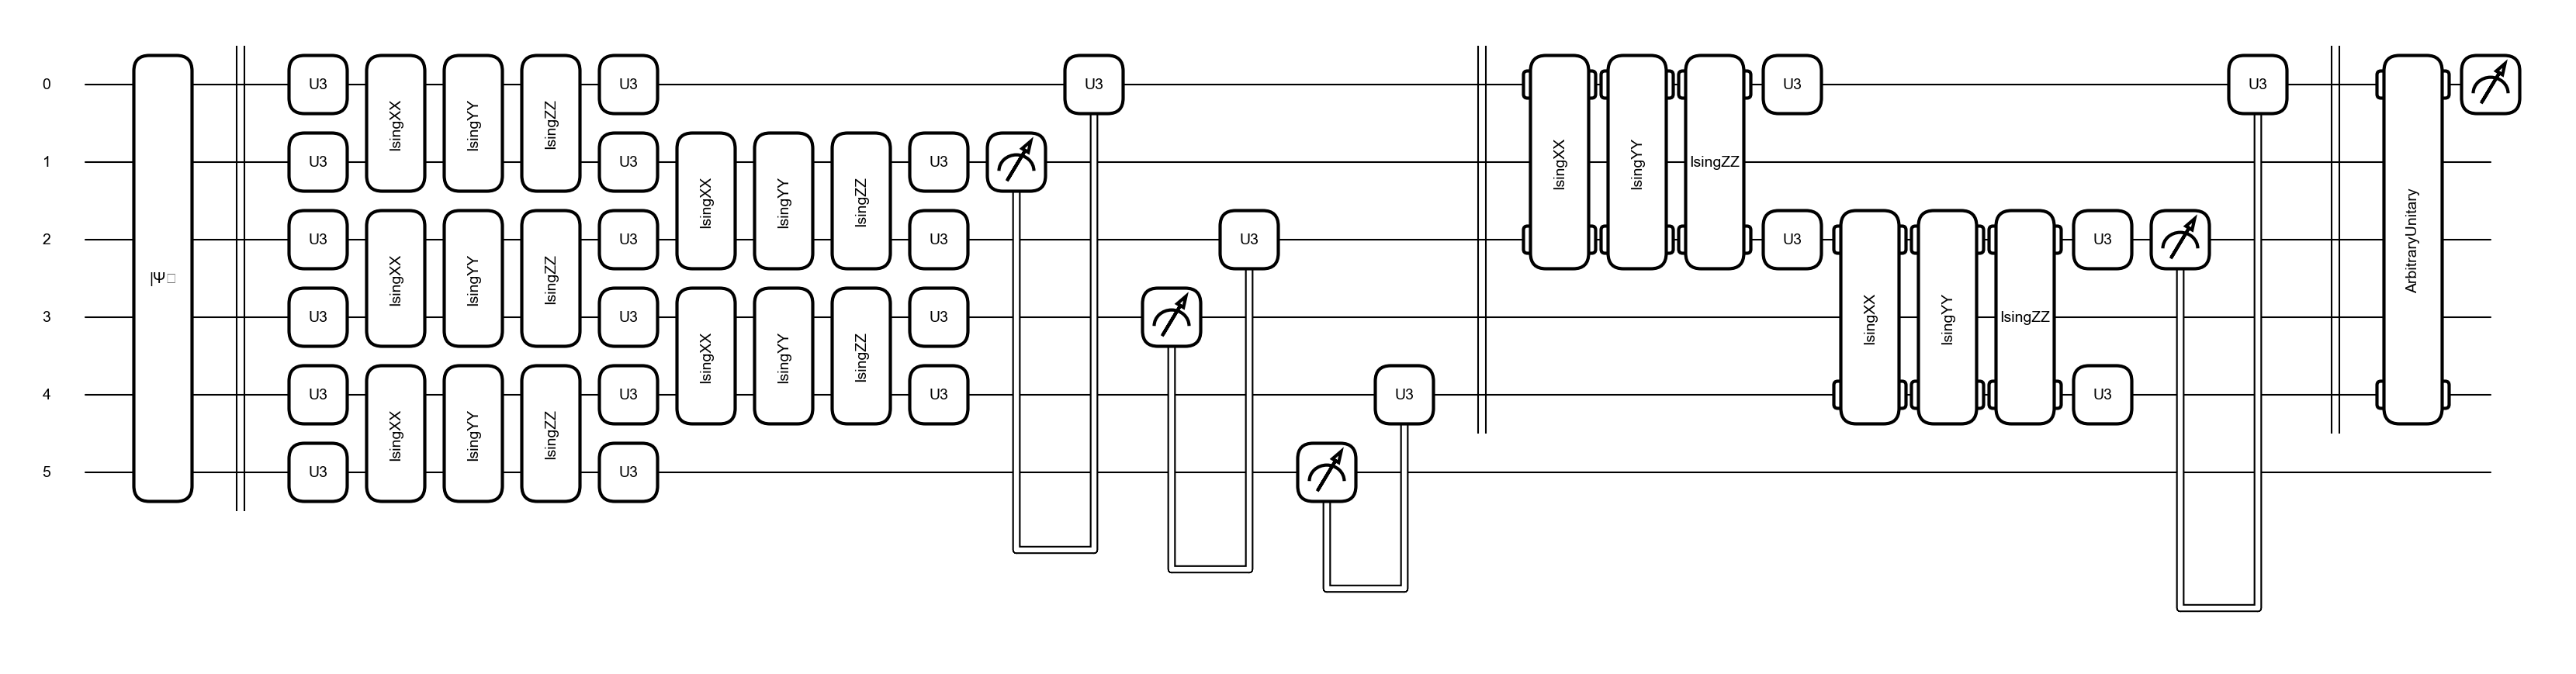

In [6]:
def conv_and_pooling(kernel_weights, n_wires, skip_first_layer=True):
    """Apply both the convolutional and pooling layer."""
    convolutional_layer(kernel_weights[:15], n_wires, skip_first_layer=skip_first_layer)
    pooling_layer(kernel_weights[15:], n_wires)


def dense_layer(weights, wires):
    """Apply an arbitrary unitary gate to a specified set of wires."""
    qml.ArbitraryUnitary(weights, wires)


num_wires = 6
device = qml.device("default.qubit", wires=num_wires)


@qml.qnode(device)
def conv_net(weights, last_layer_weights, features):
    """Define the QCNN circuit
    Args:
        weights (np.array): Parameters of the convolution and pool layers.
        last_layer_weights (np.array): Parameters of the last dense layer.
        features (np.array): Input data to be embedded using AmplitudEmbedding."""

    layers = weights.shape[1]
    wires = list(range(num_wires))

    # inputs the state input_state
    qml.AmplitudeEmbedding(features=features, wires=wires, pad_with=0.5)
    qml.Barrier(wires=wires, only_visual=True)

    # adds convolutional and pooling layers
    for j in range(layers):
        conv_and_pooling(weights[:, j], wires, skip_first_layer=(not j == 0))
        wires = wires[::2]
        qml.Barrier(wires=wires, only_visual=True)

    assert last_layer_weights.size == 4 ** (len(wires)) - 1, (
        "The size of the last layer weights vector is incorrect!"
        f" \n Expected {4 ** (len(wires)) - 1}, Given {last_layer_weights.size}"
    )
    dense_layer(last_layer_weights, wires)
    return qml.probs(wires=(0))


fig, ax = qml.draw_mpl(conv_net)(
    np.random.rand(18, 2), np.random.rand(4 ** 2 - 1), np.random.rand(2 ** num_wires)
)
plt.show()

In the problem we will address, we need to encode 64 features in our
quantum state. Thus, we require six qubits ($2^6 = 64$) to encode each
feature value in the amplitude of each computational basis state.

Training the QCNN on the digits dataset
=======================================

In this demo, we are going to classify the digits `0` and `1` from the
classical `digits` dataset. Each hand-written digit image is represented
as an $8 \times 8$ array of pixels as shown below:


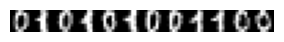

In [7]:
digits = datasets.load_digits()
images, labels = digits.data, digits.target

images = images[np.where((labels == 0) | (labels == 1))]
labels = labels[np.where((labels == 0) | (labels == 1))]

fig, axes = plt.subplots(nrows=1, ncols=12, figsize=(3, 1))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].reshape((8, 8)), cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

For convenience, we create a `load_digits_data` function that will make
random training and testing sets from the `digits` dataset from
`sklearn.dataset`:


In [8]:
def load_digits_data(num_train, num_test, rng):
    """Return training and testing data of digits dataset."""
    digits = datasets.load_digits()
    features, labels = digits.data, digits.target

    # only use first two classes
    features = features[np.where((labels == 0) | (labels == 1))]
    labels = labels[np.where((labels == 0) | (labels == 1))]

    # normalize data
    features = features / np.linalg.norm(features, axis=1).reshape((-1, 1))

    # subsample train and test split
    train_indices = rng.choice(len(labels), num_train, replace=False)
    test_indices = rng.choice(
        np.setdiff1d(range(len(labels)), train_indices), num_test, replace=False
    )

    x_train, y_train = features[train_indices], labels[train_indices]
    x_test, y_test = features[test_indices], labels[test_indices]

    return (
        jnp.asarray(x_train),
        jnp.asarray(y_train),
        jnp.asarray(x_test),
        jnp.asarray(y_test),
    )

To optimize the weights of our variational model, we define the cost and
accuracy functions to train and quantify the performance on the
classification task of the previously described QCNN:


In [9]:
@jax.jit
def compute_out(weights, weights_last, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    cost = lambda weights, weights_last, feature, label: conv_net(weights, weights_last, feature)[
        label
    ]
    return jax.vmap(cost, in_axes=(None, None, 0, 0), out_axes=0)(
        weights, weights_last, features, labels
    )


def compute_accuracy(weights, weights_last, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    return jnp.sum(out > 0.5) / len(out)


def compute_cost(weights, weights_last, features, labels):
    """Computes the cost over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    return 1.0 - jnp.sum(out) / len(labels)


def init_weights():
    """Initializes random weights for the QCNN model."""
    weights = pnp.random.normal(loc=0, scale=1, size=(18, 2), requires_grad=True)
    weights_last = pnp.random.normal(loc=0, scale=1, size=4 ** 2 - 1, requires_grad=True)
    return jnp.array(weights), jnp.array(weights_last)


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0, 1]))

We are going to perform the classification for training sets with
different values of $N.$ Therefore, we define the classification
procedure once and then perform it for different datasets. Finally, we
update the weights using the `pennylane.AdamOptimizer`{.interpreted-text
role="class"} and use these updated weights to calculate the cost and
accuracy on the testing and training set:


In [10]:
def train_qcnn(n_train, n_test, n_epochs):
    """
    Args:
        n_train  (int): number of training examples
        n_test   (int): number of test examples
        n_epochs (int): number of training epochs
        desc  (string): displayed string during optimization

    Returns:
        dict: n_train,
        steps,
        train_cost_epochs,
        train_acc_epochs,
        test_cost_epochs,
        test_acc_epochs

    """
    # load data
    x_train, y_train, x_test, y_test = load_digits_data(n_train, n_test, rng)

    # init weights and optimizer
    weights, weights_last = init_weights()

    # learning rate decay
    cosine_decay_scheduler = optax.cosine_decay_schedule(0.1, decay_steps=n_epochs, alpha=0.95)
    optimizer = optax.adam(learning_rate=cosine_decay_scheduler)
    opt_state = optimizer.init((weights, weights_last))

    # data containers
    train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []

    for step in range(n_epochs):
        # Training step with (adam) optimizer
        train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
        updates, opt_state = optimizer.update(grad_circuit, opt_state)
        weights, weights_last = optax.apply_updates((weights, weights_last), updates)

        train_cost_epochs.append(train_cost)

        # compute accuracy on training data
        train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
        train_acc_epochs.append(train_acc)

        # compute accuracy and cost on testing data
        test_out = compute_out(weights, weights_last, x_test, y_test)
        test_acc = jnp.sum(test_out > 0.5) / len(test_out)
        test_acc_epochs.append(test_acc)
        test_cost = 1.0 - jnp.sum(test_out) / len(test_out)
        test_cost_epochs.append(test_cost)

    return dict(
        n_train=[n_train] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int),
        train_cost=train_cost_epochs,
        train_acc=train_acc_epochs,
        test_cost=test_cost_epochs,
        test_acc=test_acc_epochs,
    )

There are some small intricacies for speeding up this code that are
worth mentioning. We are using `jax` for our training because it allows
for
[just-in-time](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html)
(`jit`) compilation. A function decorated with `@jax.jit` will be
compiled upon its first execution and cached for future executions. This
means the first execution will take longer, but all subsequent
executions are substantially faster. Further, we use `jax.vmap` to
vectorize the execution of the QCNN over all input states, as opposed to
looping through the training and test set at every execution.

Training for different training set sizes yields different accuracies,
as seen below. As we increase the training data size, the overall test
accuracy, a proxy for the models\' generalization capabilities,
increases:


In [11]:
n_test = 100
n_epochs = 100
n_reps = 100


def run_iterations(n_train):
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
    )

    for _ in range(n_reps):
        results = train_qcnn(n_train=n_train, n_test=n_test, n_epochs=n_epochs)
        results_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
        )

    return results_df


# run training for multiple sizes
train_sizes = [2, 5, 10, 20, 40, 80]
results_df = run_iterations(n_train=2)
for n_train in train_sizes[1:]:
    results_df = pd.concat([results_df, run_iterations(n_train=n_train)])

Finally, we plot the loss and accuracy for both the training and testing
set for all training epochs, and compare the test and train accuracy of
the model:


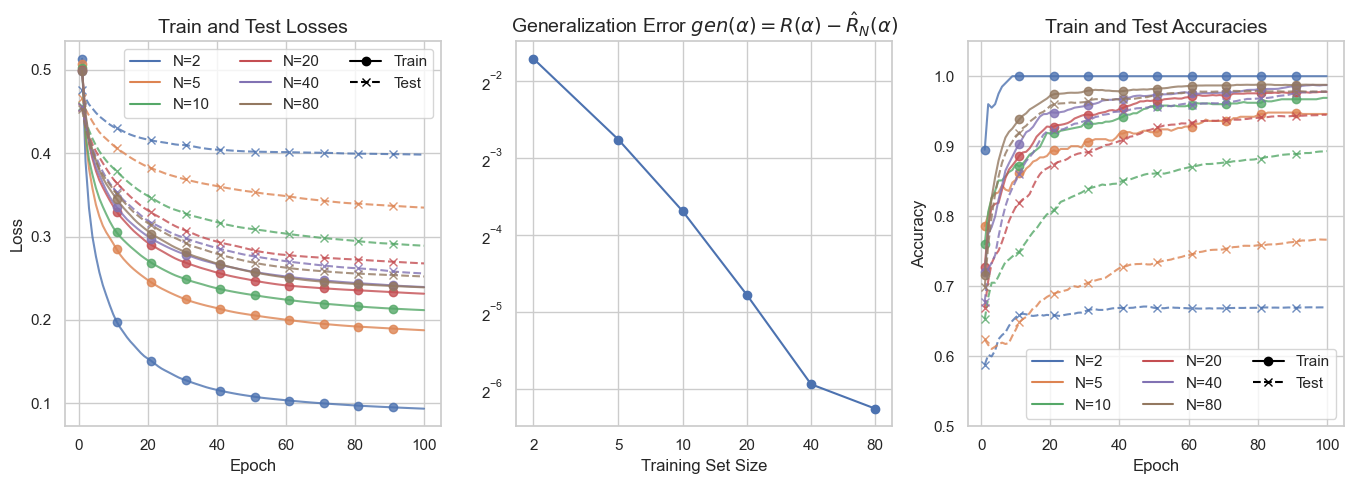

In [12]:
# aggregate dataframe
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"])
df_agg = df_agg.reset_index()

sns.set_style('whitegrid')
colors = sns.color_palette()
fig, axes = plt.subplots(ncols=3, figsize=(16.5, 5))

generalization_errors = []

# plot losses and accuracies
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train]

    dfs = [df.train_cost["mean"], df.test_cost["mean"], df.train_acc["mean"], df.test_acc["mean"]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0,0,2,2]
    
    for k in range(4):
        ax = axes[axs[k]]   
        ax.plot(df.step, dfs[k], lines[k], label=labels[k], markevery=10, color=colors[i], alpha=0.8)


    # plot final loss difference
    dif = df[df.step == 100].test_cost["mean"] - df[df.step == 100].train_cost["mean"]
    generalization_errors.append(dif)

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# format generalization error plot
ax = axes[1]
ax.plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
ax.set_xscale('log')
ax.set_xticks(train_sizes)
ax.set_xticklabels(train_sizes)
ax.set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
ax.set_xlabel('Training Set Size')

# format loss plot
ax = axes[2]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, 1.05)

legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
    ] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]

axes[0].legend(handles=legend_elements, ncol=3)
axes[2].legend(handles=legend_elements, ncol=3)

axes[1].set_yscale('log', base=2)
plt.show()

------------------------------------------------------------------------

The key takeaway of this work is that some quantum learning models can
achieve high-fidelity predictions using a few training data points. We
implemented a model known as the quantum convolutional neural network
(QCNN) using PennyLane for a binary classification task. Using six
qubits, we have trained the QCNN to distinguish between handwritten
digits of $0$\'s and $1's$. With $80$ samples, we have achieved a model
with accuracy greater than $97\%$ in $100$ training epochs. Furthermore,
we have compared the test and train accuracy of this model for a
different number of training samples and found the scaling of the
generalization error agrees with the theoretical bounds obtained in[^1].

References
==========

About the authors
=================

[^1]: Matthias C. Caro, Hsin-Yuan Huang, M. Cerezo, Kunal Sharma, Andrew
    Sornborger, Lukasz Cincio, Patrick J. Coles. \"Generalization in
    quantum machine learning from few training data\"
    [arxiv:2111.05292](https://arxiv.org/abs/2111.05292), 2021.
